# Imaginary time evolution of MPS with Quantum TEA Leaves

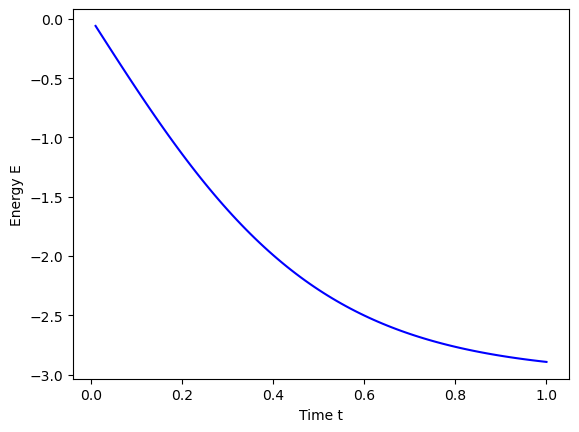

Sampled states: {'0100': 0.008672510535419816, '0101': 0.4735030313768867, '0110': 0.00867251053541973, '0111': 0.00015884257122550371, '1000': 0.00015884257122555923, '1001': 0.008672510535420064, '1010': 0.473503031376891, '1011': 0.008672510535420064, '1100': 0.0001588425712254482, '1101': 0.008672510535419842}


In [4]:
"""
Minimal example of imaginary time evolution with MPS states and TDVP.
"""
import qtealeaves as qtl
import os
from qtealeaves import modeling
import numpy as np
import matplotlib.pyplot as plt


def TN_equal_superposition_state(
    n, max_bond_dimension=16, states_folder="saved_states/", verbose=False
):
    """
    Generates a MPS representing the equal superposition of the computational basis states, saves it in a file,
    and returns the file name. The state is generated as the ground state of transverse field the Hamiltonian
    H = sum_i sigma^x_i .
    """
    state_path = states_folder + "initial_state_" + str(n)
    if not os.path.exists(states_folder):
        os.makedirs(states_folder)
    model = modeling.QuantumModel(1, "L", name="long_field")
    model += modeling.LocalTerm("sx", strength="J", prefactor=-1)
    ops = qtl.operators.TNSpin12Operators()
    conv = qtl.convergence_parameters.TNConvergenceParameters(
        max_bond_dimension=max_bond_dimension
    )
    obs = qtl.observables.TNObservables()
    obs += qtl.observables.TNState2File(state_path, "F")
    params = {"L": n, "J": 1.0}
    simulation = qtl.QuantumGreenTeaSimulation(
        model,
        ops,
        conv,
        obs,
        tn_type=6,
        tensor_backend=2,
        verbosity=False,
        store_checkpoints=False,
    )
    simulation.run(params, delete_existing_folder=True)
    return state_path + ".mps"


def TN_i_evolve(
    n, state_0, hamiltonian, time, delta_t, imag_evo_dt=0.01, max_bond_dimension=32
):
    """
    Performs imaginary time evolution, yelding at each time step the time, the name of the file where the corresponding
    mps is stored, and the energy.
    """
    if np.abs(delta_t / imag_evo_dt - int(delta_t / imag_evo_dt)) > 10 ** (-12):
        raise ValueError("delta_t must be a multiple of imag_evo_dt!")
    max_iter_for_step = int(delta_t / imag_evo_dt)
    params = {"L": n, "J": 1.0}
    ops = qtl.operators.TNSpin12Operators()
    state_tt = [state_0] + [
        state_0[:-4] + "_" + str(np.round(tt, 15)) + ".mps"
        for tt in np.arange(delta_t, time + delta_t, delta_t)
    ]
    tt = 0
    for ii in range(int(time / delta_t)):
        tt = np.round(tt + delta_t, 15)
        params["continue_file"] = state_tt[ii]
        conv = qtl.convergence_parameters.TNConvergenceParameters(
            max_iter=max_iter_for_step,
            max_bond_dimension=max_bond_dimension,
            statics_method=4,
            imag_evo_dt=imag_evo_dt,
        )
        obs = qtl.observables.TNObservables()
        obs += qtl.observables.TNState2File(state_tt[ii + 1][:-4], "F")
        simulation = qtl.QuantumGreenTeaSimulation(
            hamiltonian,
            ops,
            conv,
            obs,
            tn_type=6,
            tensor_backend=2,
            has_log_file=False,
            verbosity=False,
            store_checkpoints=False,
        )
        simulation.run(params, delete_existing_folder=True)
        yield tt, state_tt[ii + 1], simulation.get_static_obs(params)["energy"]


n = 4
time = 1
delta_t = 0.01

hamiltonian_model = modeling.QuantumModel(1, "L", name="maxcut_ising")
hamiltonian_model += modeling.TwoBodyTerm1D(["sz", "sz"], 1, strength="J", prefactor=1)


times = []
energies = []
energies_vs_probs = []
for tt, state, energy in TN_i_evolve(
    n, TN_equal_superposition_state(n), hamiltonian_model, time, delta_t
):
    times.append(tt)
    energies.append(energy)

# Plot energy evolution
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(times, energies, "b-")
ax1.set_xlabel("Time t")
ax1.set_ylabel("Energy E")
plt.show()

# Sample computational states distribution
n_samples = 100
psi = qtl.emulator.MPS.read(state, qtl.tensors.TensorBackend())
probs_dict = psi.meas_unbiased_probabilities(
    n_samples, do_return_samples=False, precision=15
)
probs_dict = {conf: float(upper - lower) for conf, (lower, upper) in probs_dict.items()}
print("Sampled states:", probs_dict)